In [1]:
#Module imports
import pickle
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import ast

In [13]:
property_df = pd.read_csv("datasets/property_vector_pickle_2020-12-12-expanded.csv", sep="\t")
# dataset that contains patient id and rfs (target feature)
bc_df = pd.read_csv("datasets/bclinical.csv", dtype={"RFS": "int64"})

df = pd.merge(bc_df, property_df, on="patient_ID")
df.info()
#drop rows that have NA for RFS
df = df.dropna(axis=0, subset=["RFS"])
df.RFS = df.RFS.astype(int)

ValueError: Integer column has NA values in column 1

In [15]:
X = df[df.columns.difference(["patient_ID", "RFS"])].to_numpy()
y = df["RFS"].to_numpy(dtype=np.int64)
# X = np.fromstring(X)
pos, neg = df[df["RFS"] == 1].shape[0], df[df["RFS"] == 0].shape[0]

print("{:.2%} of the samples has RFS 1".format((pos / df.shape[0])))

71.46% of the samples has RFS 1


In [23]:
import scipy
# X = X.reshape(X.shape[0], -1)
# y = y.reshape(X.shape[0], -1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)

In [24]:
#xgboost parameters
param = {
    'eta': 0.2, #learning rate
    'max_depth': 3, #maximum depth that model trees can grow
    'objective': 'binary:logistic', #loss function
}
steps = 50
model = xgb.cv(param, D_train, nfold=5, )

[19:03:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [26]:
preds = model.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

# print("Precision = {}".format(precision_score(y_test, preds)))
# print("Recall = {}".format(recall_score(y_test, preds)))
# print("Accuracy on test = {}".format(accuracy_score(y_test, preds)))
# print("Accuracy on train = {}".format(accuracy_score(y_train, preds)))

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [27]:
#compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

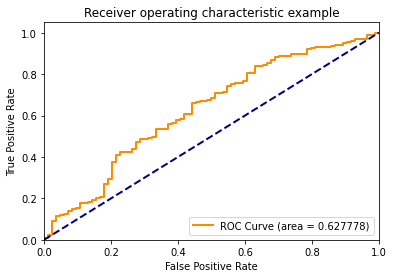

In [29]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw,
         label='ROC Curve (area = %f)' % roc_auc)
plt.plot([0,1], [0,1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

No handles with labels found to put in legend.


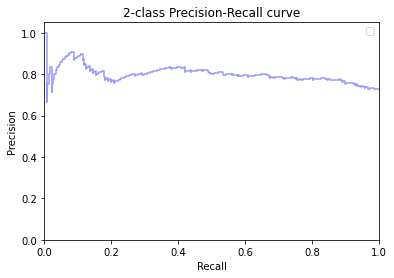

In [46]:
#compare the precision-recall at d/t thresholds
from sklearn.metrics import precision_recall_curve, accuracy_score
precision, recall, thresholds = precision_recall_curve(y_test, preds)

thresholds = np.append(thresholds, 1)
f1_scores = 2*(precision*recall)/(precision + recall)
plt.step(recall, precision, color='b', alpha=0.4, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve')
plt.legend()
plt.show()

Threshold cutoff: 0.2977
Max F1-score at cut-off: 0.8443
F1-score at threshold 0.5 cutoff: 0.8311


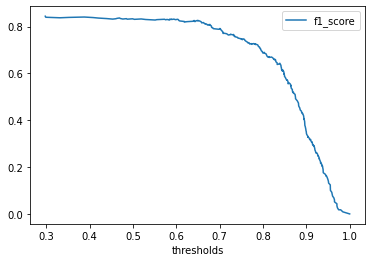

In [45]:
# F1 score at various thresholds
scores_df = pd.DataFrame({'precision': precision, 'recall': recall, 'thresholds': thresholds, 'f1_score': f1_scores})
print("Threshold cutoff: {:.4f}".format(scores_df.loc[scores_df['f1_score'] == scores_df.f1_score.max(), "thresholds"].iloc[0]))
print("Max F1-score at cut-off: {:.4f}".format(scores_df.f1_score.max()))
print("F1-score at threshold 0.5 cutoff: {:.4f}".format(scores_df.loc[scores_df['thresholds'] >= 0.50 , "f1_score"].iloc[0]))
scores_df.plot(x="thresholds", y="f1_score")
plt.axvline(x=0.5,color='red', lw=lw, linestyle='--'
            , label="Default threshold at 0.5")
scores_df.to_csv("datasets/thresholds_f1.csv")

In [ ]:
r